In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numba
import keras
import scipy.stats
import seaborn as sns
sns.set_context('notebook')

In [0]:
# this code is required for Ex 1
def display_image(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

def fully_connected(ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return np.random.uniform(-boundary, boundary, size=(ninputs, noutputs))

def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.sum()

def ReLU(X):
    return np.maximum(X, 0)

def dReLU(X):
    return (X > 0).astype(float)

def drop(X, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = np.random.rand(X.shape[1]) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X[:, ~keeps] = 0 # ignore
        X[:, keeps] *= (1/keep_prob) # normalize
    return X

def predict(Ws, X):
    if X.ndim == 1:
        X = X.reshape((1, -1))
    return feed_forward(Ws, X, keep_prob=1)[-1]

def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print(prediction)
    return display_image(X_test[idx])

def loss(Ws, X, Y):
    Yhat = predict(Ws, X)
    return cross_entropy(Yhat, Y)

def gradient_check(Ws, X, Y, Δ=1e-5):
    dWs = back_propagation(Ws, X, Y, keep_prob=1)
    Ws_ = [W.copy() for W in Ws]
    
    for i, (W_, dW_) in enumerate(zip(Ws_, dWs)):
        print('W{}'.format(i+1))
        for i in range(W_.shape[0]):
            for j in range(W_.shape[1]):
                dw = dW_[i, j]
                W_[i,j] += Δ
                loss1 = loss(Ws_, X, Y)
                W_[i,j] -= 2*Δ
                loss2 = loss(Ws_, X, Y)
                W_[i,j] += Δ
                dw_ = (loss1 - loss2) / (2 * Δ)
                rel_error = abs(dw - dw_) / abs(dw + dw_)
                if not np.isclose(dw_, dw):
                    print(i, j, dw, dw_, rel_error)
                
def average(prev, curr, β):
    return [β * p + (1 - β) * c for p, c in zip(prev, curr)]

In [0]:
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ε=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ε = ε
        self.m = None
        self.v = None
        self.t = 0
    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)
        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)
        self.v = average(self.v, (g*g for g in gradients), self.β2)
        updates = [-αt * mi / (np.sqrt(vi) + self.ε) for mi, vi in zip(self.m
        , self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates
    def trainer(Ws, X, Y, optimizer, batch_size=50, keep_prob=1):
        nsamples = X.shape[0]
        batch = 0
        while True:
            # get next batch
            start = (batch * batch_size) % nsamples
            stop = start + batch_size
            batch_idx = range(start, stop)
            X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
            gradients = back_propagation(Ws, X_, Y_, keep_prob=keep_prob) # calculate gradients
            ΔWs = optimizer.send(gradients) # calculate updatesfor W, ΔW in zip(Ws, ΔWs): # apply updates
            W += ΔW
            batch += 1
            yield batch

In [0]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

In [0]:
def feed_forward(Ws, X, keep_prob=1):
    X1 = X
    W1, W2 = Ws
    # hidden layer
    Z1 = X1 @ W1
    Z1 = drop(Z1, keep_prob=keep_prob)
    X2 = ReLU(Z1)
    # readout layer
    Z2 = X2 @ W2
    Yhat = softmax(Z2)
    return [X1, Z1, X2, Z2, Yhat]
  
def back_propagation(Ws, X, Y, keep_prob=1):
    W1, W2 = Ws
    X1, Z1, X2, Z2, Yhat = feed_forward(Ws, X, keep_prob=keep_prob)
    # readout layer
    δ2 = Yhat - Y # prediction error, dJ/dYhat * dYhat/dZ2 (-1, ncats)
    dW2 = X2.T @ δ2 # dJ/dW2 = δ2 * dZ2/dX2 = δ2 * X2
    # hidden layer
    δ1 = (δ2 @ W2.T) * dReLU(Z1) # δ1 = dJ/dX_2 = δ2 * dZ2/dX2 * dX2/dZ1 = δ2 * W2 * ReLU(Z1)
    dW1 = X1.T @ δ1 # dJ/dW1 = δ1 * dZ1/dW1 = δ1 * X1
    gradients = [dW1, dW2]
    # sanity checks
    assert len(gradients) == len(Ws), (len(gradients), len(Ws))
    for dW, W in zip(gradients, Ws):
        assert dW.shape == W.shape, (dW.shape, W.shape)
    return gradients

In [0]:
def trainer(Ws, X, Y, optimizer, batch_size=50, keep_prob=1):
    nsamples = X.shape[0]
    batch = 0
    while True:
        # get next batch
        start = (batch * batch_size) % nsamples
        stop = start + batch_size
        batch_idx = range(start, stop)
        X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
        gradients = back_propagation(Ws, X_, Y_, keep_prob=keep_prob) # calculate gradients
        ΔWs = optimizer.send(gradients) # calculate updates
        for W, ΔW in zip(Ws, ΔWs): # apply updates
            W += ΔW
        batch += 1
        yield batch

In [0]:
# create model here
nhidden = 100
W1 = fully_connected(nfeatures, nhidden)
W2 = fully_connected(nhidden, ncats)
Ws = [W1, W2]

In [0]:
# Before training, weak model, bad results, very unimpressive
acc = accuracy(predict(Ws, X_test), Y_test) ###
print(acc)

0.0998


In [0]:
# Model works hard, joins some kind of a gym, and after some intense workout for many epochs, gets fully trained
adm = AdamOptimizer()
train = trainer(Ws, X_train, Y_train, optimizer=AdamOptimizer(), keep_prob=0.5)
for batch in train:
    if batch == 10 * nsamples // 50: break

In [0]:
# After training, strong model, good results, looks dope!
acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy ({:d}): {:.4f}".format(batch, acc))

Accuracy (12000): 0.9177


In [0]:
# Ex2 starts from here
import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.optimizers import adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

Keras 2.2.4
GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() ###

In [0]:
# Pre-processing and normalizing the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Resaping the data
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Applying one-hot-encoding
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [0]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


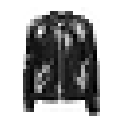

In [0]:
# Let's see the images
i = np.random.randint(0, x_train.shape[0])
plt.figure(figsize=(2,2))
plt.imshow(x_train[i, :, :, 0], cmap='gray_r')
plt.xticks([]); plt.yticks([])
print(y_train[i])

In [0]:
# Create a Keras Model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [0]:
# Initialize optimizer and compile model
opt = adam(lr = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [0]:
model.fit(x_train, y_train, validation_split=0.3, shuffle=True, verbose=0, epochs=60, batch_size=256)

In [0]:
loss, acc = model.evaluate(x_test, y_test, verbose=1) ###
print('Test loss:', loss) ###
print('Test accuracy:', acc) ###

10000/10000 [==============================] - 1s 138us/step
Test loss: 0.22896832135915757
Test accuracy: 0.9199


In [0]:
# Ex 3 starts from here

# Loading the mnist digits dataset
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

# Keras model from the lecture at: https://github.com/yoavram/SciComPy/blob/27d1bc656ef925de340bf7e4b0d427b272d9ed17/notebooks/CNN.ipynb
model = keras.models.Sequential()
model.add(
    keras.layers.Reshape(target_shape=(width, height, 1), 
                         input_shape=(width, height)))
model.add(
    keras.layers.Conv2D(32, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Conv2D(64, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.Dropout(0.5))
model.add(
    keras.layers.Dense(ncats))
model.add(
    keras.layers.Softmax())

keras.utils.plot_model(model, to_file='tmp.png')
keras.preprocessing.image.load_img('tmp.png')

model.summary()

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), 
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, 
    validation_data=(X_test, Y_test),
).history

model.save('keras_cnn_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [0]:
# releasing the resources
del model
del X_test
del X_train
del Y_test
del Y_train

In [0]:
# reloading the saved model
model = keras.models.load_model('keras_cnn_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [0]:
# Now we have the model. What needs to be done is listed as follows:
# 1.) Make all layers non-trainable
# 2.) Pop/Remove the last layer dense and softmax layers
# 3.) Add the last dense layer with 10 neurons, and a softmax activation function layer
# 4.) Recompile the model

for layer in model.layers:
  layer.trainable = False
  
model.pop()
model.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
model.add(
    keras.layers.Dense(ncats))
model.add(
    keras.layers.Softmax())
# Compile the model here
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), 
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [0]:
# Reloading the fashion mnist data again
(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

In [0]:
# train model here
model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.8722 - acc: 0.7147 - val_loss: 0.6921 - val_acc: 0.7711
Epoch 2/5
60000/60000 [==============================] - 7s 119us/step - loss: 0.6740 - acc: 0.7705 - val_loss: 0.6237 - val_acc: 0.7974
Epoch 3/5
60000/60000 [==============================] - 7s 122us/step - loss: 0.6329 - acc: 0.7817 - val_loss: 0.5947 - val_acc: 0.8012
Epoch 4/5
60000/60000 [==============================] - 7s 119us/step - loss: 0.6184 - acc: 0.7857 - val_loss: 0.5794 - val_acc: 0.8075
Epoch 5/5
60000/60000 [==============================] - 7s 118us/step - loss: 0.6064 - acc: 0.7893 - val_loss: 0.5651 - val_acc: 0.8092


In [0]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1) ###
print('Test loss:', loss) ###
print('Test accuracy:', acc) ###

10000/10000 [==============================] - 1s 93us/step
Test loss: 0.5651335227966309
Test accuracy: 0.8092


In [0]:
# In Ex 2, the model reached a test accuracy of 0.92 after 60 epochs, and in transfer learning approach, the model got to 0.80 test accuracy after only 5 epochs.